In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
from tensorflow.keras import layers
from keras_cv import utils
from keras_cv.layers import BaseImageAugmentationLayer
import matplotlib.pyplot as plt
import numpy as np


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [3]:
print(tf.__version__)
from platform import python_version

print(python_version())

2.9.1
3.10.6


In [4]:
def imshow(img):
    img = img.astype(int)
    plt.axis("off")
    plt.imshow(img)
    plt.show()


def gallery_show(images):
    images = images.astype(int)
    fig = plt.figure(figsize=(20,20))
    for i in range(images.shape[0]):
        image = images[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.axis("off")
    plt.show()

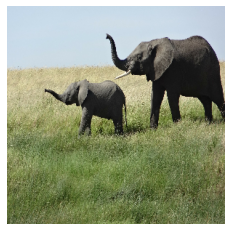

In [5]:
SIZE = (300, 300)
elephants = tf.keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)
elephants = tf.keras.utils.load_img(elephants, target_size=SIZE)
elephants = tf.keras.utils.img_to_array(elephants)
imshow(elephants)

min and max before augmentation: 0.0 1.0
Here is the transformation: tf.Tensor(0.82613, shape=(), dtype=float32)
min and max after augmentation: 0.0 1.0


2022-10-16 14:48:17.147824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:48:17.147983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:48:17.148091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:48:17.476678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 14:48:17.476800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

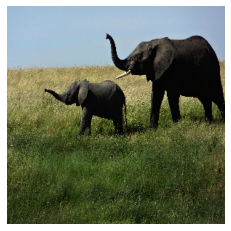

In [6]:
class RandomBlueTint(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint randomly applies a blue tint to images.

    Args:
      value_range: value_range: a tuple or a list of two elements. The first value
        represents the lower bound for values in passed images, the second represents
        the upper bound. Images passed to the layer should have values within
        `value_range`.
      factor: A tuple of two floats, a single float or a
        `keras_cv.FactorSampler`. `factor` controls the extent to which the
        image is blue shifted. `factor=0.0` makes this layer perform a no-op
        operation, while a value of 1.0 uses the degenerated result entirely.
        Values between 0 and 1 result in linear interpolation between the original
        image and a fully blue image.
        Values should be between `0.0` and `1.0`.  If a tuple is used, a `factor` is
        sampled between the two values for every image augmented.  If a single float
        is used, a value between `0.0` and the passed float is sampled.  In order to
        ensure the value is always the same, please pass a tuple with two identical
        floats: `(0.5, 0.5)`.
    """

    def __init__(self, value_range, factor, **kwargs):
        super().__init__(**kwargs)
        self.value_range = value_range
        self.factor = utils.parse_factor(factor)
        self.auto_vectorize = False

    def get_random_transformation(self, **kwargs):
        # kwargs holds {"images": image, "labels": label, etc...}
        return self.factor() 

    def augment_image(self, image, transformation=None, **kwargs):
        image = utils.transform_value_range(image, self.value_range, (0, 1))
        print("Here is the transformation:",transformation)
        # print(image)
        # blue = tf.clip_by_value(blue + transformation, 0.0, 255.0)
        
        mult = image * image
        image = (mult*transformation) + (image * (1-transformation))
        image = tf.clip_by_value(image, 0.0, 1.0)
        # result = utils.transform_value_range(result, self.value_range, (0, 255))
        
        return image
        
        # image = image * image
        
        # # [*others, blue] = tf.unstack(image, axis=-1)
        # tf.clip_by_value(image, 0.0, 255.0)
        # return image

    def augment_label(self, label, transformation=None, **kwargs):
        return label

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # you can also perform no-op augmentations on label types to support them in
        # your pipeline.
        return bounding_boxes


layer = RandomBlueTint(value_range=(0, 1), factor=(0.1, 1.0))
elephants_0_1 = elephants / 255
print("min and max before augmentation:", elephants_0_1.min(), elephants_0_1.max())
augmented = layer(elephants_0_1)
print(
    "min and max after augmentation:",
    augmented.numpy().min(),
    augmented.numpy().max(),
)
imshow((augmented * 255).numpy().astype(int))

In [7]:
class RandomMultiply(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint randomly applies a blue tint to images.

    Args:
      factor: A tuple of two floats, a single float or a
        `keras_cv.FactorSampler`. `factor` controls the extent to which the
        image is blue shifted. `factor=0.0` makes this layer perform a no-op
        operation, while a value of 1.0 uses the degenerated result entirely.
        Values between 0 and 1 result in linear interpolation between the original
        image and a fully blue image.
        Values should be between `0.0` and `1.0`.  If a tuple is used, a `factor` is
        sampled between the two values for every image augmented.  If a single float
        is used, a value between `0.0` and the passed float is sampled.  In order to
        ensure the value is always the same, please pass a tuple with two identical
        floats: `(0.5, 0.5)`.
    """

    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = utils.parse_factor(factor)
        # this disables BaseImageAugmentationLayer's Auto Vectorization
        self.auto_vectorize = False

    def get_random_transformation(self, **kwargs):
        # kwargs holds {"images": image, "labels": label, etc...}
        return self.factor() * 255

    def augment_image(self, image, transformation=None, **kwargs):
        image = image / 255
        image = image * image
        image = image * 255
        # [*others, blue] = tf.unstack(image, axis=-1)
        tf.clip_by_value(image, 0.0, 255.0)
        return image
        

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # you can also perform no-op augmentations on label types to support them in
        # your pipeline.
        return bounding_boxes

In [8]:
import keras_cv
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

augmenter = keras_cv.layers.Augmenter(
  layers=[
      # keras.layers.Rescaling(scale=1./255),
      keras_cv.layers.RandomFlip(),
      # RandomBlueTint(value_range=(0, 1), factor=(0.1, 1.0)),
      # keras_cv.layers.RandAugment(value_range=(0, 255)),
      # keras_cv.layers.CutMix(),
      # keras_cv.layers.MixUp()
    ]
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

def augment_data(images, labels):
  labels = tf.one_hot(labels, 8)
  inputs = {"images": images, "labels": labels}
  outputs = augmenter(inputs)
  return outputs['images'], outputs['labels']

In [9]:
dataset, info = tfds.load('deep_weeds', as_supervised=True, split='train', with_info=True)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

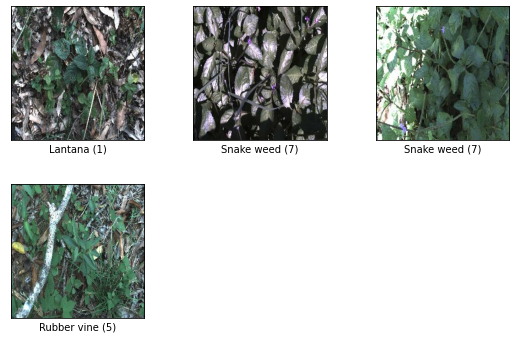

In [10]:
fig = tfds.show_examples(dataset.take(4), info)

In [11]:
dataset = dataset.batch(64)
dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
densenet = keras_cv.models.DenseNet121(
  include_rescaling=True,
  include_top=True,
  classes=8
)
densenet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
history = densenet.fit(dataset, epochs=10)

Epoch 1/10


2022-10-16 14:48:26.642497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-10-16 14:48:29.210929: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


274/274 [==============================] - 84s 258ms/step - loss: 0.8993 - accuracy: 0.1984
Epoch 2/10
274/274 [==============================] - 68s 246ms/step - loss: 0.9625 - accuracy: 0.1494
Epoch 3/10
274/274 [==============================] - 68s 246ms/step - loss: 0.9961 - accuracy: 0.1606
Epoch 4/10
274/274 [==============================] - 68s 246ms/step - loss: 1.0015 - accuracy: 0.1213
Epoch 5/10
274/274 [==============================] - 68s 246ms/step - loss: 0.9985 - accuracy: 0.1246
Epoch 6/10
274/274 [==============================] - 62s 223ms/step - loss: 0.9989 - accuracy: 0.1324
Epoch 7/10
274/274 [==============================] - 62s 225ms/step - loss: 0.9952 - accuracy: 0.1238
Epoch 8/10
274/274 [==============================] - 62s 224ms/step - loss: 0.9959 - accuracy: 0.1239
Epoch 9/10
274/274 [==============================] - 62s 224ms/step - loss: 0.9979 - accuracy: 0.1294
Epoch 10/10
274/274 [==============================] - 62s 224ms/step - loss: 0.9954